In [4]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

#train neural network on load and weather features
#identify annual, then monthly CP's
#include load forecast as feature

In [5]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [6]:
#ercot 2017 loads

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")

testloads = np.array(list(ercot2017['ERCOT']))

In [7]:
startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = np.array(allhours[0:-8760]) #all but last year, not a leap year
testhours = np.array(allhours[-8760:])

#get indecies of day starts in testhours
startdate = datetime.datetime(year=2017, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

day_start_i = []
i = 0

while curr < enddate:
    if curr.hour == 0:
        day_start_i.append(i)
    curr += datetime.timedelta(hours=1)
    i += 1

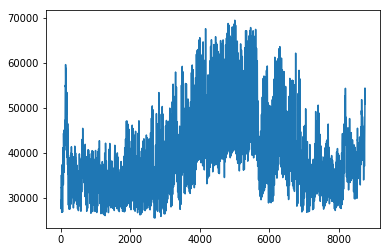

array([datetime.datetime(2017, 7, 28, 15, 0),
       datetime.datetime(2017, 7, 28, 16, 0),
       datetime.datetime(2017, 7, 28, 14, 0),
       datetime.datetime(2017, 7, 20, 15, 0),
       datetime.datetime(2017, 7, 27, 15, 0)], dtype=object)

In [8]:
#July peak was calculated to have occured at datetime.datetime(2017, 7, 28, 17, 0)

plt.plot(testloads)
plt.show()
testhours[testloads.argsort()[-5:][::-1]]

570.2781314827672 36556.57900951147


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


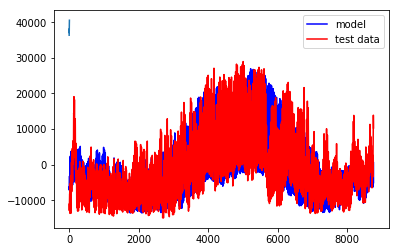

In [9]:
#ERCOT data
lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx")
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #dropping leap days so years line up

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

yearly_data = [ercot2010, ercot2011, ercot2012, ercot2013, ercot2014, ercot2015, ercot2016, ercot2017]
training = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT'])]
means = [ np.nanmean(y) for y in training ]

#use system-wide loadgrowth for all regions
A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
a, b = np.linalg.lstsq(A, np.array(means))[0]
print(a, b)
projected_mean = a*7.0 + b
plt.plot(means + [projected_mean])
means.append(projected_mean)
load_growth = np.array(means)

yearly_loads = np.zeros((8,8760))

for i in range(len(yearly_data)):
    yearly_loads[i,:] = np.array(yearly_data[i]['ERCOT']) - load_growth[i]
    
model = np.nanmean(yearly_loads[0:6,:], axis=0)
test = yearly_loads[7,:]
plt.plot(model, color="blue", label="model")
plt.plot(test, color="red", label="test data")
plt.legend()
plt.show()

In [10]:
np.where(np.isnan(yearly_loads))

(array([6]), array([7439]))

In [11]:
month_blocks = {}
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016]
days_month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
for j in range(len(years)):
    year_index = j*8760
    for i in range(12):
        month = i+1
        year = years[j]
        day_of_year = 0
        for k in range(month):
            day_of_year += days_month[k]
        num_days = days_month[month]
        month_blocks[str(year) + "_" + str(month)] = yearly_loads[j,day_of_year*24:(day_of_year + num_days)*24]

744
[-4562.15432058 -5044.02072758 -5051.43227458]
[ -9357.45056807  -9904.55947407 -10017.92332307]
[-10328.81390424 -11530.79399424 -12290.83391824]
[-10821.88801312 -11708.54320112 -12265.42862712]
[-11512.69952023 -12570.06906923 -13068.06465023]
[-8011.93364803 -8881.14192503 -9110.99513003]
[-9036.88307352 -9633.28225452 -9753.88428352]


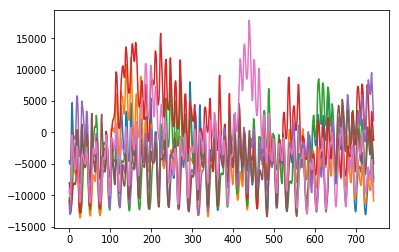

In [12]:
month = 12

print(len(month_blocks[str(years[0]) + "_" + str(month)]))

for y in years:
    plt.plot(month_blocks[str(y) + "_" + str(month)])
    print(month_blocks[str(y) + "_" + str(month)][0:3])
    
plt.show()

In [13]:
#generate CDF for each month, create time series of CDF values

In [15]:
month_CDF_labels = {}

for y in years:
    for month in range(12):
        month += 1
        month_CDF_labels[str(y) + "_" + str(month)] = []
        demands = month_blocks[str(y) + "_" + str(month)]
        
        for j in range(len(month_blocks[str(y) + "_" + str(month)])):
            greater = np.sum([1 for k in demands if k >= demands[j]])/float(len(demands))
            month_CDF_labels[str(y) + "_" + str(month)].append(1.0 - greater)

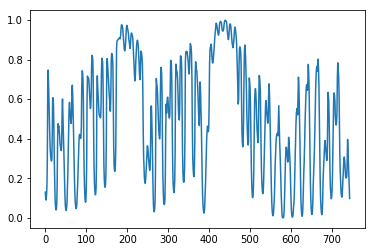

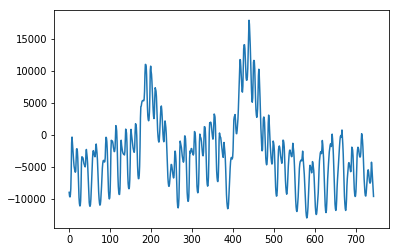

In [18]:
plt.plot(month_blocks[str(y) + "_12"])
plt.show()